In [1]:
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
from sklearn import datasets

# Adaboost

In [2]:
class DecisionStump():
    """One level decision tree
    """
    def __init__(self):
        # Flag to indicate whether sample is classified as
        # 1 or -1 based on threshold comparison
        self.polarity = 1
        # Feature index used to split
        self.feature_index = None
        # Threshold value used to split
        self.threshold = None
        # Alpha - indicative of classifier's accuracy
        self.alpha = None

In [16]:
class Adaboost():
    """Adaboost classifier
    """
    def __init__(self, n_clf=5):
        self.n_clf = n_clf
    
    def fit(self, x, y):
        """Fit a set of weak learners
        Learn which feature,threshold to set and corresponding alpha
        (classifier accuracy) which will be used to weight in prediction
        """
        n_samples, n_features = x.shape
        self.clfs = []
        w = np.full(n_samples, (1/n_samples))

        for _ in range(self.n_clf):
            clf = DecisionStump()
            min_error = float("inf")

            # Find the best feature to split on
            for feature_i in range(n_features):
                feature_values = np.expand_dims(x[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)

                # Find the best threshold to split on
                for threshold in unique_values:
                    # Init predictions to all ones
                    pred = np.ones(np.shape(y))
                    # Set polarity to 1
                    polarity = 1
                    # Set -1 when feature values are less than threshold
                    negative_idx = x[:, feature_i] < threshold
                    pred[negative_idx] = -1

                    # Calculate error (sum of weighted samples)
                    error = sum(w[y != pred])

                    # If error is > 0.5, flip predictions
                    if error > 0.5:
                        polarity = -1
                        error = 1 - error

                    # Record this feature, threshold if error is better
                    # than previous best
                    if min_error > error:
                        min_error = error
                        clf.polarity = polarity
                        clf.threshold = threshold
                        clf.feature_index = feature_i
            
            # Calculate alpha for the best classifier (based on min_error)
            clf.alpha = 0.5 * math.log((1 - min_error)/(min_error + 1e-10))

            # Get predictions for this best classifier
            pred = np.ones(np.shape(y))
            negative_idx = (clf.polarity * x[:, clf.feature_index] < clf.polarity * clf.threshold)
            pred[negative_idx] = -1

            # Weight samples based on misclassifications 
            # The ones which are misclassified will get larger weights
            w *= np.exp(-clf.alpha * y * pred)
            # Normalise weights
            w /= sum(w)

            # Append this classifier
            self.clfs.append(clf)
    
    def predict(self, x):
        """ Get predictions for adaboost model
        Weighted (alpha) sum of each weak learner's output
        """
        n_samples = np.shape(x)[0]
        y_pred = np.zeros((n_samples,1))

        for clf in self.clfs:
            pred = np.ones((n_samples, 1))
            negative_idx = (clf.polarity * x[:, clf.feature_index] < clf.polarity * clf.threshold)
            pred[negative_idx] = -1
            # Weighted (alpha) sum of predictions from weak learners
            y_pred += clf.alpha * pred
        y_pred = np.sign(y_pred).flatten()
        return y_pred


Accuracy: 0.9325842696629213


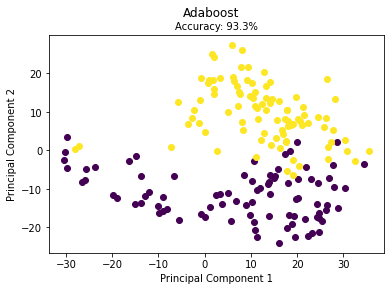

In [22]:
from sklearn.model_selection import train_test_split

def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy

data = datasets.load_digits()
X = data.data
y = data.target

digit1 = 1
digit2 = 8
idx = np.append(np.where(y == digit1)[0], np.where(y == digit2)[0])
y = data.target[idx]
# Change labels to {-1, 1}
y[y == digit1] = -1
y[y == digit2] = 1
X = data.data[idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Adaboost classification with 5 weak classifiers
clf = Adaboost(n_clf=15)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print ("Accuracy:", accuracy)

# Reduce dimensions to 2d using pca and plot the results
Plot().plot_in_2d(X_test, y_pred, title="Adaboost", accuracy=accuracy)


In [4]:
import progressbar
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import numpy as np

def standardize(X):
    """ Standardize the dataset X """
    X_std = X
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]
    # X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    return X_std

def calculate_covariance_matrix(X, Y=None):
    """ Calculate the covariance matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)
 

def calculate_correlation_matrix(X, Y=None):
    """ Calculate the correlation matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance = (1 / n_samples) * (X - X.mean(0)).T.dot(Y - Y.mean(0))
    std_dev_X = np.expand_dims(calculate_std_dev(X), 1)
    std_dev_y = np.expand_dims(calculate_std_dev(Y), 1)
    correlation_matrix = np.divide(covariance, std_dev_X.dot(std_dev_y.T))

    return np.array(correlation_matrix, dtype=float)


bar_widgets = [
    'Training: ', progressbar.Percentage(), ' ', progressbar.Bar(marker="-", left="[", right="]"),
    ' ', progressbar.ETA()
]

class Plot():
    def __init__(self): 
        self.cmap = plt.get_cmap('viridis')

    def _transform(self, X, dim):
        covariance = calculate_covariance_matrix(X)
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        # Sort eigenvalues and eigenvector by largest eigenvalues
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :dim]
        # Project the data onto principal components
        X_transformed = X.dot(eigenvectors)

        return X_transformed


    def plot_regression(self, lines, title, axis_labels=None, mse=None, scatter=None, legend={"type": "lines", "loc": "lower right"}):
        
        if scatter:
            scatter_plots = scatter_labels = []
            for s in scatter:
                scatter_plots += [plt.scatter(s["x"], s["y"], color=s["color"], s=s["size"])]
                scatter_labels += [s["label"]]
            scatter_plots = tuple(scatter_plots)
            scatter_labels = tuple(scatter_labels)

        for l in lines:
            li = plt.plot(l["x"], l["y"], color=s["color"], linewidth=l["width"], label=l["label"])

        if mse:
            plt.suptitle(title)
            plt.title("MSE: %.2f" % mse, fontsize=10)
        else:
            plt.title(title)

        if axis_labels:
            plt.xlabel(axis_labels["x"])
            plt.ylabel(axis_labels["y"])

        if legend["type"] == "lines":
            plt.legend(loc="lower_left")
        elif legend["type"] == "scatter" and scatter:
            plt.legend(scatter_plots, scatter_labels, loc=legend["loc"])

        plt.show()



    # Plot the dataset X and the corresponding labels y in 2D using PCA.
    def plot_in_2d(self, X, y=None, title=None, accuracy=None, legend_labels=None):
        X_transformed = self._transform(X, dim=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        class_distr = []

        y = np.array(y).astype(int)

        colors = [self.cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

        # Plot the different class distributions
        for i, l in enumerate(np.unique(y)):
            _x1 = x1[y == l]
            _x2 = x2[y == l]
            _y = y[y == l]
            class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

        # Plot legend
        if not legend_labels is None: 
            plt.legend(class_distr, legend_labels, loc=1)

        # Plot title
        if title:
            if accuracy:
                perc = 100 * accuracy
                plt.suptitle(title)
                plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
            else:
                plt.title(title)

        # Axis labels
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')

        plt.show()

    # Plot the dataset X and the corresponding labels y in 3D using PCA.
    def plot_in_3d(self, X, y=None):
        X_transformed = self._transform(X, dim=3)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        x3 = X_transformed[:, 2]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x1, x2, x3, c=y)
        plt.show()